In [1]:
import os
import numpy as np
import scipy.io as scio
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


class SVHN():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = np.array([])
        self._training_labels = np.array([])
        self._test_data = np.array([])
        self._test_labels = np.array([])
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    
    def _load_traing_data(self):
        self._training_data, self._training_labels = self._load_data("train_32x32.mat")        
    
    def _load_test_data(self):
        self._test_data, self._test_labels = self._load_data("test_32x32.mat")
    
    def _rgb2gray(self, rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    def _load_data(self, file):
        path = os.path.join(self._directory, file)
        
        mat = scio.loadmat(path)
        data = np.moveaxis(mat["X"], 3, 0)
        data = self._rgb2gray(data)
        data = data.reshape(data.shape + (1,))
        
        labels = mat["y"].reshape(mat["y"].shape[0])
        labels[labels == 10] = 0
        
        return data, labels
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [2]:
dataset = SVHN()

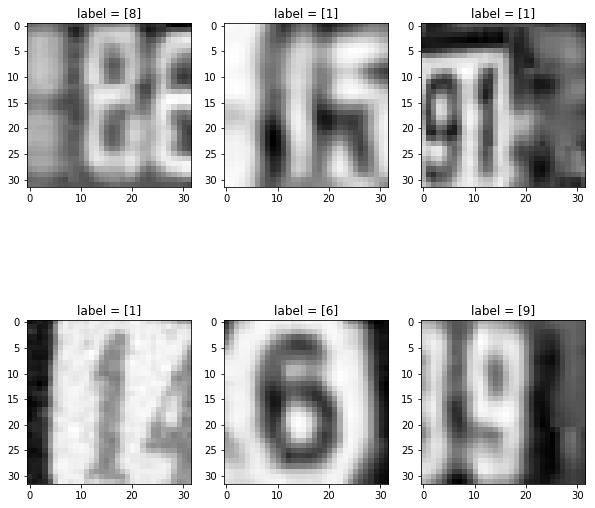

In [3]:
plt.figure(figsize=(10,10))
for i in range(6):
    image, label = next(dataset.get_validation_batch(1))
    plt.subplot(2, 3, i+1)
    plt.imshow(image.reshape(32,32), cmap='Greys')
    plt.title('label = ' + str(label))

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b


epochs = 50
batch_size = 300

# Define placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
y = tf.placeholder(tf.int64, shape=[None])
keep_probs = tf.placeholder(tf.float32)

C1, C2, C3 = 10, 20, 30
F1 = 100

conv1_1 = conv_layer(x, shape=[3, 3, 1, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = tf.nn.max_pool(conv1_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
conv1_drop = tf.nn.dropout(conv1_pool, keep_probs)


conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = tf.nn.max_pool(conv2_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv2_drop = tf.nn.dropout(conv2_pool, keep_probs)

conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3_drop = tf.nn.dropout(conv3_pool, keep_probs)
conv3_flat = tf.reshape(conv3_drop, [-1, 4 * 4 * C3])
full1 = tf.nn.relu(full_layer(conv3_flat, F1))
full1_drop = tf.nn.dropout(full1, keep_probs)


out = full_layer(full1_drop, 10)


cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=out))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)


accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(out,1), y),
    tf.float32))

training_acc, training_loss = [], []

saver = tf.train.Saver()
# initialize the network
init = tf.global_variables_initializer()


In [10]:
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session,  tf.train.latest_checkpoint("./weights/"))
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(dataset.get_test_batch(300)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, y: labels, keep_probs: 1.0}
        )
    
print("Test Accuracy: " + str(test_accuracy / step))


INFO:tensorflow:Restoring parameters from ./weights/model_100.ckpt
Test Accuracy: 0.936000005638
